Based on the idea of "Hierarchical multimodal transformers for Multi-Page DocVQA" (https://arxiv.org/pdf/2212.05935), page 5

In [1]:
import clip
import torch
import matplotlib.pyplot as plt
from PIL import Image
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, _ = clip.load("ViT-B/32", device=device) # 1x512
clip_model.eval()
for param in clip_model.parameters():
	param.requires_grad = False
input_size = 224

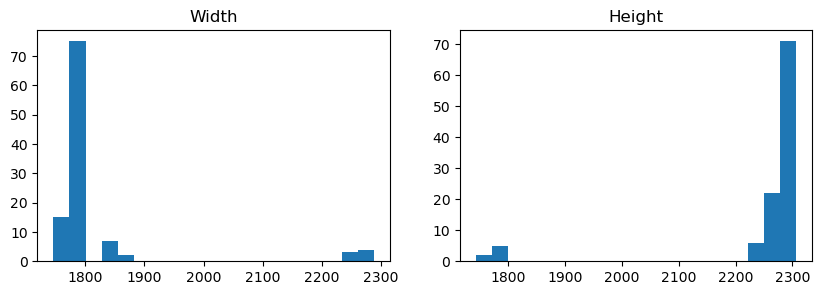

In [2]:
# histogram of image sizes (one for w another for h) in "images/" directory
images = os.listdir("images/")
w = []
h = []
for image in images:
	img = Image.open("images/" + image)
	w.append(img.size[0])
	h.append(img.size[1])

# fit both histograms in the figure
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].hist(w, bins=20)
axs[0].set_title("Width")
axs[1].hist(h, bins=20)
axs[1].set_title("Height")
plt.show()

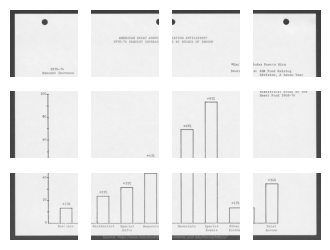

In [72]:
import math

def resize_by_ratio(image, ratio):
	"""Resize image by a ratio."""
	width, height = image.size
	new_width = math.ceil(width * ratio)
	new_height = math.ceil(height * ratio)
	resized_image = image.resize((new_width, new_height))
	return resized_image

def resize_to_shortest_side(image, size):
	"""Resize image so that the shortest side is of a given size."""
	width, height = image.size
	if width < height:
		new_width = size
		new_height = math.ceil(height / width * size)
	else:
		new_height = size
		new_width = math.ceil(width / height * size)
	resized_image = image.resize((new_width, new_height))
	return resized_image

def resize_to_nearest_multiple(image, multiple):
	"""Resize image so that its dimensions are multiples of a given number."""
	width, height = image.size
	new_width = math.ceil(width / multiple) * multiple
	new_height = math.ceil(height / multiple) * multiple
	resized_image = image.resize((new_width, new_height))
	return resized_image

def img2chunks(image, chunk_size):
	"""Split image into chunks of a given size."""
	width, height = image.size
	chunks = []
	for top in range(0, height, chunk_size):
		for left in range(0, width, chunk_size):
			box = (left, top, left + chunk_size, top + chunk_size)
			patch = image.crop(box)
			chunks.append(patch)
	return chunks, (height // chunk_size, width // chunk_size)

imgX = Image.open("images/jzhd0227_p81.jpg")
imgX = resize_to_shortest_side(imgX, input_size*3)
imgX = resize_to_nearest_multiple(imgX, input_size)
chunksX, (rows, cols) = img2chunks(imgX, input_size)
plot_size = 3
fig, axs = plt.subplots(rows, cols, figsize=(imgX.size[0] / min(imgX.size) * plot_size, imgX.size[1] / min(imgX.size) * plot_size))
for i, ax in enumerate(axs.flatten()):
	ax.imshow(chunksX[i])
	ax.axis("off")
plt.show()

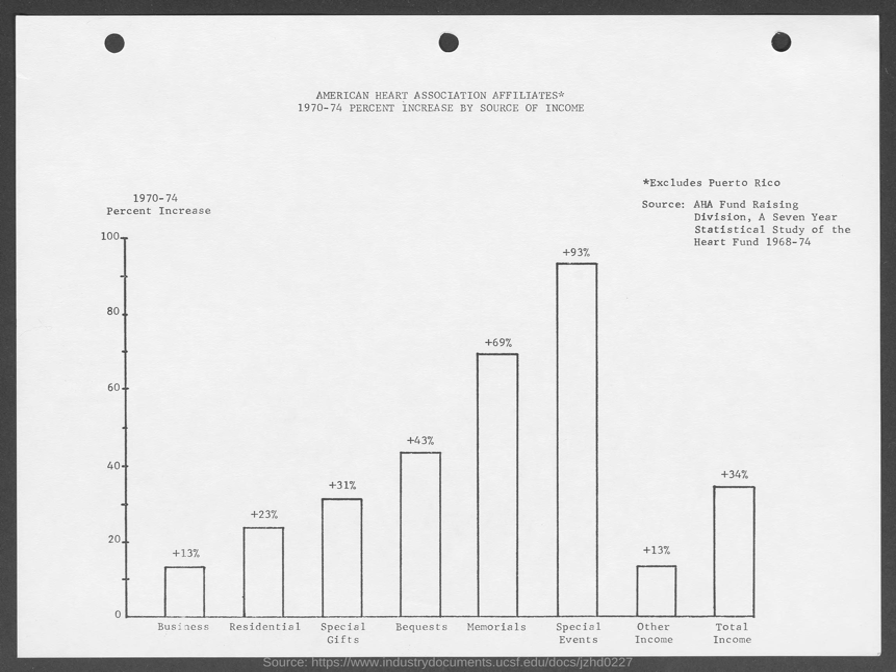

In [87]:
imgX

In [92]:
import json
trainset = json.load(open("qas/train.json"))
ex_qas = [qa for qa in trainset["data"] if qa["page_ids"][qa["answer_page_idx"]] == "jzhd0227_p81"]
i = 0
q_index = 0
for qa in [qa for qa in trainset["data"] if qa["doc_id"] == "jzhd0227"]:
	if qa["question"] == ex_qas[i]["question"]:
		break
	q_index += 1
print(q_index)
ex_qas[i]

43


{'questionId': 25902,
 'question': 'what is the percentage increase by source of income of business from 1970-74 mentioned in the given graph ?',
 'doc_id': 'jzhd0227',
 'page_ids': ['jzhd0227_p80',
  'jzhd0227_p81',
  'jzhd0227_p82',
  'jzhd0227_p83',
  'jzhd0227_p84'],
 'answers': ['+13%', '13', '+ 13 %'],
 'answer_page_idx': 1,
 'data_split': 'train'}

In [69]:
import numpy as np
ex_chunk = chunksX[0].convert("RGB")
ex_chunk = torch.tensor(np.array(ex_chunk), dtype=torch.uint8, device=device).permute(2, 0, 1).unsqueeze(0).float() / 255.
print(ex_chunk.shape)
ex_embs = clip_model.encode_image(ex_chunk)
print(ex_embs.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 512])
